In [1]:
import pandas as pd

# TripAdvisor otel yorumları veri setini yükleyelim
df = pd.read_csv("hotelReviews.csv")
print("Toplam yorum sayısı:", len(df))

# Veri yapısını görmek için ilk birkaç satırı gösterelim
df.head(5)

Toplam yorum sayısı: 68785


,hotel_url,profile_reviewer,rating,review_title,review_text,date
0,/Hotel_Review-g293974-d15235441-Reviews-Radiss...,/Profile/knight07,5,Would definitely recommend,Very close to mall and many restaurants. Great...,Nov 2023
1,/Hotel_Review-g293974-d15235441-Reviews-Radiss...,/Profile/tripswaytourism,5,"‪Radisson Collection Hotel, Vadistanbul‬","May the peace, blessings, and mercy of God be ...",Oct 2023
2,/Hotel_Review-g293974-d15235441-Reviews-Radiss...,/Profile/FredericF207,5,Lovely stay and amazing view,"Amazing staff and service, we have stayed for ...",Aug 2023
3,/Hotel_Review-g293974-d15235441-Reviews-Radiss...,/Profile/alevit595800,4,exallent,staff very helpful friendly and polite!good lo...,Aug 2023
4,/Hotel_Review-g293974-d15235441-Reviews-Radiss...,/Profile/don3ziz,5,Good hotel next to the mall,Good location next to tge mall and not far fro...,Aug 2023


<ipython-input-2-2408115500>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="rating", ax=axes[0], palette="Blues_r")


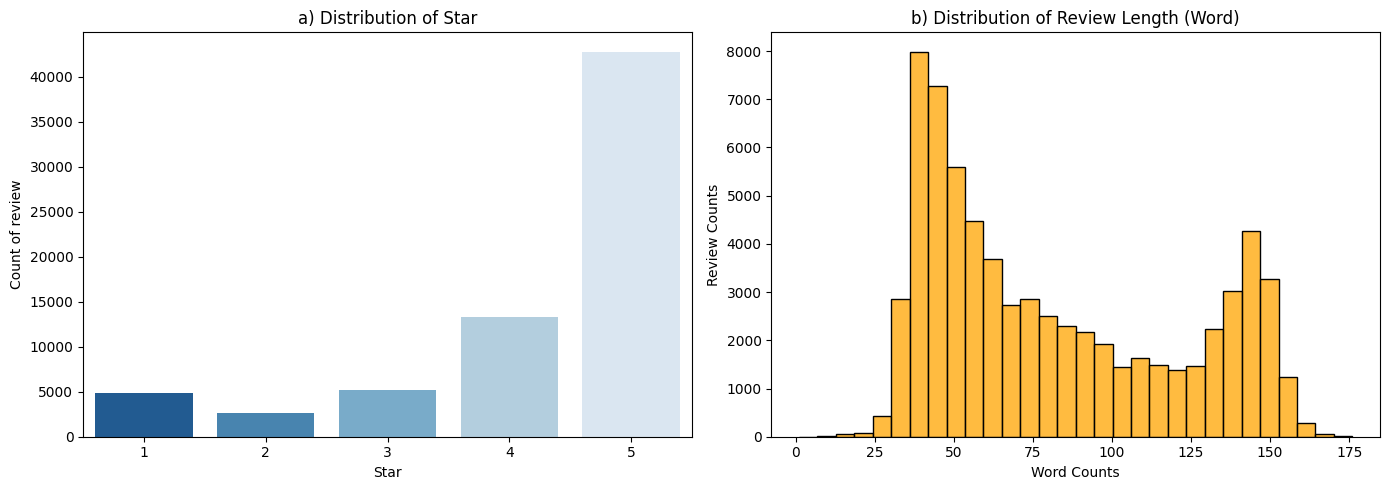

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Yorum uzunluklarını hesapla
df["review_length"] = df["review_text"].apply(lambda x: len(str(x).split()))

# 1. madde: Yıldız puanı ve yorum uzunluğu dağılımları
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# a) Yıldız puanı dağılımı
sns.countplot(data=df, x="rating", ax=axes[0], palette="Blues_r")
axes[0].set_title("a) Distribution of Star")
axes[0].set_xlabel("Star")
axes[0].set_ylabel("Count of review")

# b) Yorum uzunluğu dağılımı
sns.histplot(df["review_length"], bins=30, kde=False, ax=axes[1], color="orange")
axes[1].set_title("b) Distribution of Review Length (Word)")
axes[1].set_xlabel("Word Counts")
axes[1].set_ylabel("Review Counts")

plt.tight_layout()
#plt.suptitle("Graph 1: Star and Distribution of Review Length", fontsize=14, y=1.05)
plt.show()

In [3]:
# Her bir yorumun kelime sayısını hesaplayalım
review_lengths = df['review_text'].astype(str).apply(lambda x: len(x.split()))

# Yorum uzunluklarına dair özet istatistikler (ortalama, medyan, yüzde 95, 99)
print(review_lengths.describe(percentiles=[0.5, 0.95, 0.99]))

count    68785.000000
mean        81.386407
std         39.779297
min          1.000000
50%         69.000000
95%        149.000000
99%        156.000000
max        176.000000
Name: review_text, dtype: float64


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import re
from collections import Counter

# Tüm yorumları tek bir büyük metin haline getirelim ve küçültelim
all_text = " ".join(df['review_text'].astype(str)).lower()

# Noktalama işaretlerini kaldır (kelime frekansı analizi için)
all_text_clean = re.sub(r"[^\w\s]", " ", all_text)
words = all_text_clean.split()

# Kelime frekanslarını say
freq = Counter(words)
print("10 most frequent word (stopwords included):", freq.most_common(10))

# İngilizce durak kelimelerini çıkarıp tekrar en sık kelimelere bakalım
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words_nostop = [w for w in words if w not in stop_words]
freq_nostop = Counter(words_nostop)
print("10 most frequent word (stopwords excluded):", freq_nostop.most_common(10))

10 most frequent word (stopwords included): [('the', 339160), ('and', 232464), ('to', 144903), ('a', 127123), ('is', 106371), ('was', 100065), ('hotel', 94000), ('in', 91255), ('i', 82929), ('of', 76599)]
10 most frequent word (stopwords excluded): [('hotel', 94000), ('room', 46955), ('staff', 42162), ('good', 36261), ('breakfast', 33437), ('location', 28800), ('clean', 28279), ('stay', 26911), ('great', 26093), ('rooms', 25706)]


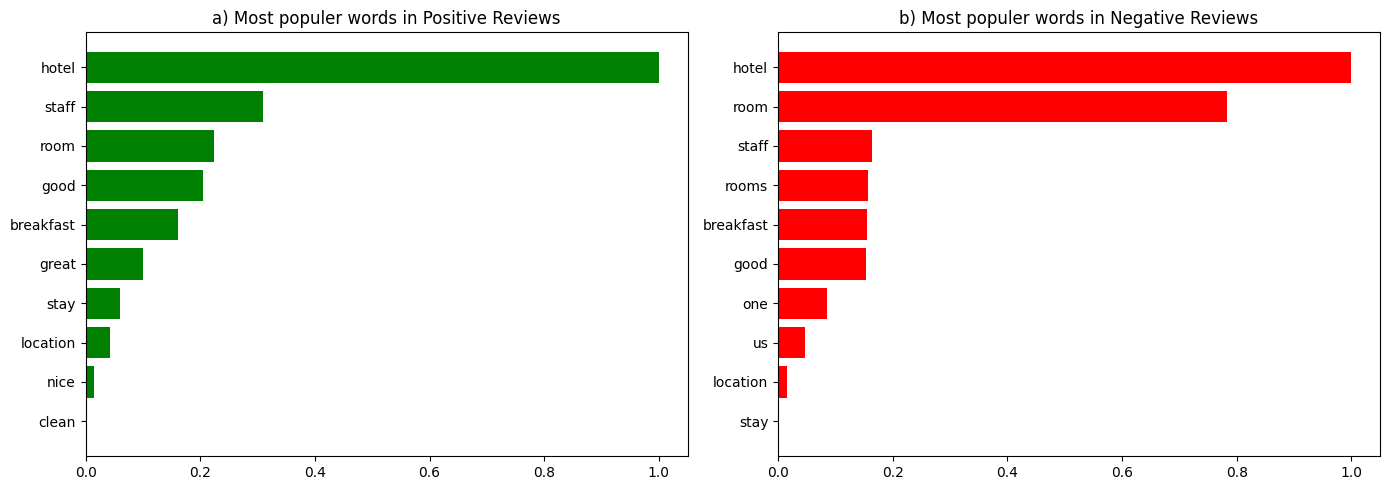

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def preprocess_text(text):
    tokens = str(text).lower().split()
    filtered = [word for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(filtered)

df["clean_text"] = df["review_text"].apply(preprocess_text)

# Pozitif ve negatif yorumları ayır
positive_reviews = df[df["rating"] >= 4]["clean_text"]
negative_reviews = df[df["rating"] <= 3]["clean_text"]

# CountVectorizer ile en sık geçen 10 kelime
def get_top_words(text_series, top_n=10):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text_series)
    total_counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    word_freq = dict(zip(vocab, total_counts))
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Normalize et (0-1 arası)
    words, freqs = zip(*sorted_words)
    scaler = MinMaxScaler()
    normalized_freqs = scaler.fit_transform(np.array(freqs).reshape(-1, 1)).flatten()

    return list(words), normalized_freqs

pos_words, pos_freqs = get_top_words(positive_reviews)
neg_words, neg_freqs = get_top_words(negative_reviews)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pozitif
axes[0].barh(pos_words, pos_freqs, color='green')
axes[0].set_title("a) Most populer words in Positive Reviews")
axes[0].invert_yaxis()

# Negatif
axes[1].barh(neg_words, neg_freqs, color='red')
axes[1].set_title("b) Most populer words in Negative Reviews")
axes[1].invert_yaxis()

#plt.suptitle("Şekil 2: Pozitif ve Negatif Yorumlarda En Popüler 10 Kelime (Normalize Edilmiş)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

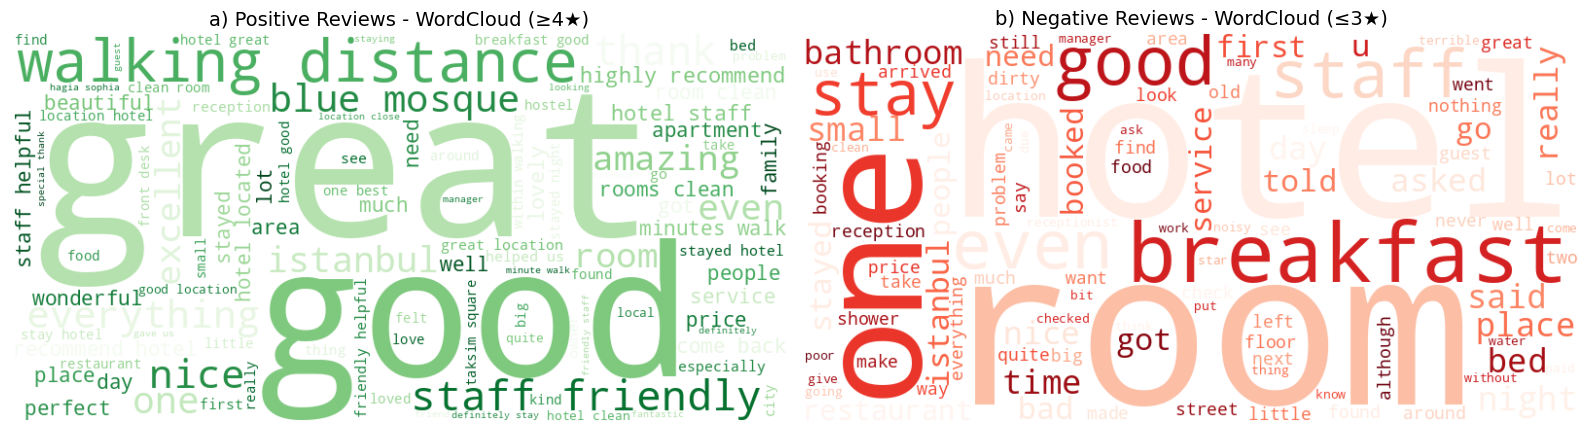

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Pozitif ve negatif yorumları al
positive_text = " ".join(df[df['rating'] >= 4]["clean_text"])
negative_text = " ".join(df[df['rating'] <= 3]["clean_text"])

# Ortak stopwords (zaten temizleme yaptıysan bu adım ekstra koruma sağlar)
stopwords = set(STOPWORDS)

# WordCloud nesneleri
positive_wc = WordCloud(width=800, height=400, background_color="white", colormap="Greens",
                        stopwords=stopwords, max_words=100).generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color="white", colormap="Reds",
                        stopwords=stopwords, max_words=100).generate(negative_text)

# Subgraph ile çizim
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# a) Pozitif WordCloud
axes[0].imshow(positive_wc, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("a) Positive Reviews - WordCloud (≥4★)", fontsize=14)

# b) Negatif WordCloud
axes[1].imshow(negative_wc, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("b) Negative Reviews - WordCloud (≤3★)", fontsize=14)

#plt.suptitle("Şekil 4: Pozitif ve Negatif Yorumlar için WordCloud Görselleştirmesi", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

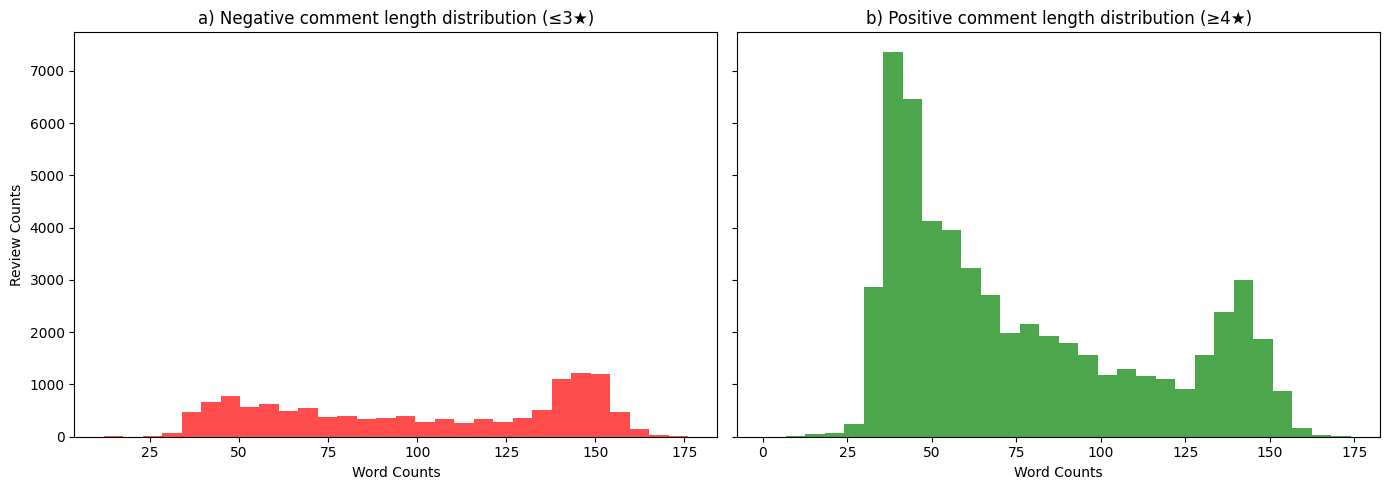

In [8]:
import matplotlib.pyplot as plt

# Yorum uzunluklarını hesapla
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Gruplar
positive_lengths = df[df['rating'] >= 4]['review_length']
negative_lengths = df[df['rating'] <= 3]['review_length']

# Subgraph oluştur
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# a) Negatif yorumlar
axes[0].hist(negative_lengths, bins=30, color='red', alpha=0.7)
axes[0].set_title("a) Negative comment length distribution (≤3★)")
axes[0].set_xlabel("Word Counts")
axes[0].set_ylabel("Review Counts")

# b) Pozitif yorumlar
axes[1].hist(positive_lengths, bins=30, color='green', alpha=0.7)
axes[1].set_title("b) Positive comment length distribution (≥4★)")
axes[1].set_xlabel("Word Counts")

# Genel başlık
#plt.suptitle("Şekil 3: Yorum Uzunluğu Dağılımı - Pozitif ve Negatif", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

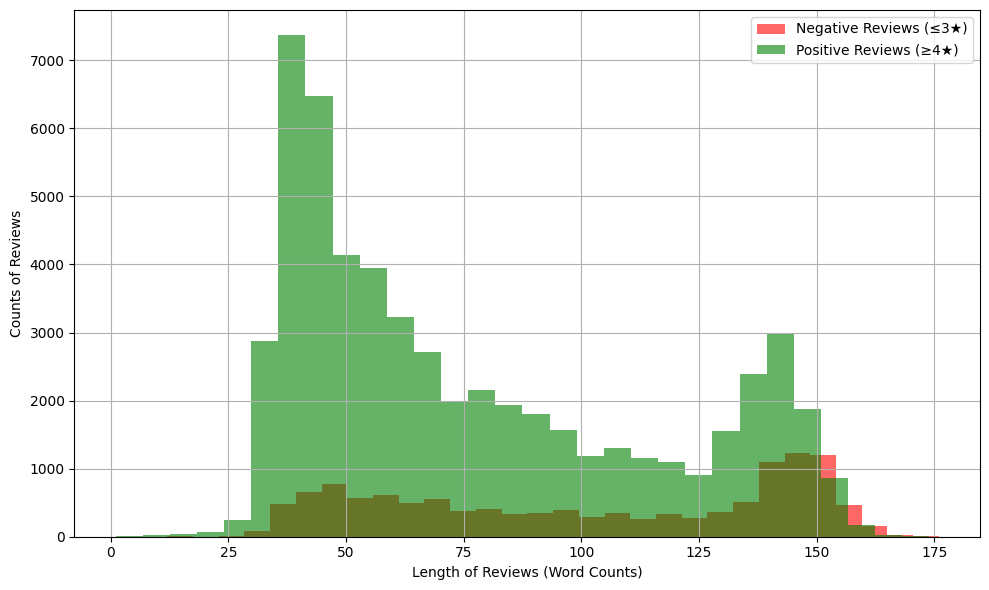

In [9]:
import matplotlib.pyplot as plt

# Yorum uzunluklarını hesapla (kelime bazında)
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Pozitif ve negatif yorumlar
positive_lengths = df[df['rating'] >= 4]['review_length']
negative_lengths = df[df['rating'] <= 3]['review_length']

# Histogram (dağılım) çizimi
plt.figure(figsize=(10, 6))
plt.hist(negative_lengths, bins=30, alpha=0.6, color='red', label='Negative Reviews (≤3★)')
plt.hist(positive_lengths, bins=30, alpha=0.6, color='green', label='Positive Reviews (≥4★)')
#plt.title("Şekil 3: Yorum Uzunluğu Dağılımı - Pozitif vs Negatif")
plt.xlabel("Length of Reviews (Word Counts)")
plt.ylabel("Counts of Reviews")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Küçük harfe çevir
    text = text.lower()
    # Noktalama işaretlerini kaldır
    text = re.sub(r"[^\w\s]", " ", text)
    # Kelimelere böl
    tokens = nltk.word_tokenize(text)
    # Durak kelimeleri çıkar ve kelimeleri köklerine (lemma) indirgeme
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    # Tekrar metne birleştir
    return " ".join(tokens)

# Örnek kullanım:
sample_review = df['review_text'].iloc[0]
print("Original:", sample_review)
print("After preprocessing:", preprocess_text(sample_review))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Original: Very close to mall and many restaurants. Great location for shopping and dining out. Very professional and polite reception staff. Special thanks to Celal Yayla from the reception staff. Also I highly appreciate another staff who was courteous, polite and attentive, his name is Salahattin Başoğul. Would definitely stay again!
After preprocessing: close mall many restaurant great location shopping dining professional polite reception staff special thanks celal yayla reception staff also highly appreciate another staff courteous polite attentive name salahattin başoğul would definitely stay


In [11]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# (Opsiyonel) Hızlı deneme amaçlı veri setini bir alt kümeye indirmek:
# df = df.sample(20000, random_state=42)

# Tabakalı şekilde eğitim (%80) ve test (%20) olarak ayır
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating'])
print("Training data count:", len(train_df), "Test data count:", len(test_df))

# Model için etiketleri 0-4 aralığına çek (1★->0, 2★->1, ..., 5★->4)
train_df['label'] = train_df['rating'] - 1
test_df['label'] = test_df['rating'] - 1

# HuggingFace Dataset formatına dönüştür (sadece review_text ve label alanlarıyla)
train_dataset = Dataset.from_pandas(train_df[['review_text','label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['review_text','label']].reset_index(drop=True))

Training data count: 55028 Test data count: 13757



DistilBERT model training...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/55028 [00:00<?, ? examples/s]

Map:   0%|          | 0/13757 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.600800,0.567883,0.763175,0.592753,0.753852,0.977176
2,0.488200,0.583783,0.763829,0.609731,0.757842,0.978646


DistilBERT Training 1270.88 took seconds


DistilBERT evaluation metrics: {'eval_loss': 0.5837828516960144, 'eval_accuracy': 0.7638293232536163, 'eval_f1_macro': 0.6097309227378467, 'eval_f1_weighted': 0.7578419175721738, 'eval_roc_auc': 0.9786456372503012, 'eval_runtime': 46.4773, 'eval_samples_per_second': 295.994, 'eval_steps_per_second': 18.504, 'epoch': 2.0}
DistilBERT confusion matrix:
 [[ 777  124   56   10   10]
 [ 149  186  163   16    7]
 [  51  128  462  330   66]
 [   5   14  208 1319 1114]
 [   7    3   26  762 7764]]

BERT model training...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/55028 [00:00<?, ? examples/s]

Map:   0%|          | 0/13757 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.602400,0.564223,0.766228,0.590811,0.752560,0.978081
2,0.479500,0.577354,0.764120,0.610862,0.760765,0.980477


BERT Training 2518.91 took seconds


BERT evaluation metrics: {'eval_loss': 0.5773541331291199, 'eval_accuracy': 0.7641200843207094, 'eval_f1_macro': 0.6108623127883955, 'eval_f1_weighted': 0.7607653065109687, 'eval_roc_auc': 0.9804768704190169, 'eval_runtime': 92.2686, 'eval_samples_per_second': 149.097, 'eval_steps_per_second': 9.321, 'epoch': 2.0}
BERT confusion matrix:
 [[ 762  147   51    4   13]
 [ 148  179  170   19    5]
 [  49  111  470  362   45]
 [   4   14  198 1413 1031]
 [   2    3   18  851 7688]]

RoBERTa model training...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/55028 [00:00<?, ? examples/s]

Map:   0%|          | 0/13757 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.611600,0.573495,0.767464,0.610984,0.760683,0.979223
2,0.505700,0.566526,0.768409,0.613160,0.761232,0.980364


RoBERTa Training 2544.72 took seconds


RoBERTa evaluation metrics: {'eval_loss': 0.5665258169174194, 'eval_accuracy': 0.7684088100603329, 'eval_f1_macro': 0.6131596829569801, 'eval_f1_weighted': 0.7612316185408505, 'eval_roc_auc': 0.9803639441685589, 'eval_runtime': 89.5005, 'eval_samples_per_second': 153.709, 'eval_steps_per_second': 9.609, 'epoch': 2.0}
RoBERTa confusion matrix:
 [[ 802  109   47    7   12]
 [ 174  164  159   19    5]
 [  51  104  485  340   57]
 [   5    6  195 1329 1125]
 [   4    3   26  738 7791]]

DeBERTa model training...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Map:   0%|          | 0/55028 [00:00<?, ? examples/s]

Map:   0%|          | 0/13757 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.589800,0.554638,0.771534,0.599802,0.761904,0.980142
2,0.488300,0.557305,0.773643,0.626688,0.768450,0.981562


DeBERTa Training 3237.43 took seconds


DeBERTa evaluation metrics: {'eval_loss': 0.5573050379753113, 'eval_accuracy': 0.773642509268009, 'eval_f1_macro': 0.626688220384575, 'eval_f1_weighted': 0.7684497147709664, 'eval_roc_auc': 0.9815619466833427, 'eval_runtime': 122.0733, 'eval_samples_per_second': 112.695, 'eval_steps_per_second': 7.045, 'epoch': 2.0}
DeBERTa confusion matrix:
 [[ 785  120   56    3   13]
 [ 155  186  155   19    6]
 [  40  114  508  327   48]
 [   5    7  198 1383 1067]
 [   2    3   17  759 7781]]


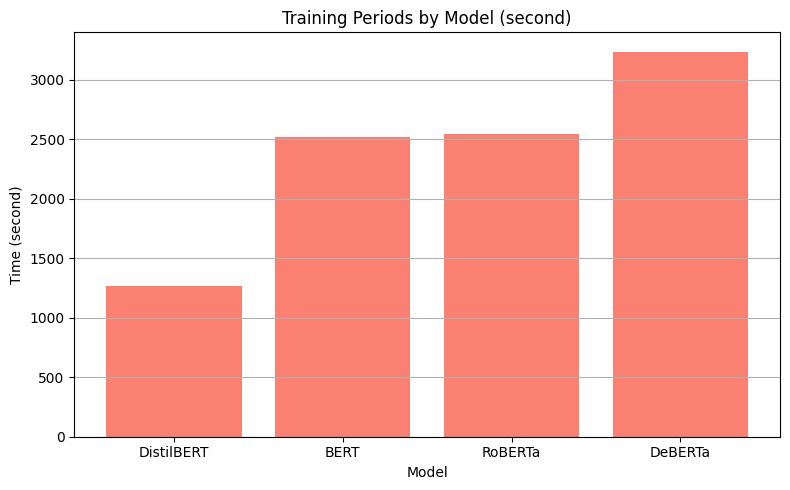

In [12]:
import numpy as np
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from datasets import Dataset

training_durations = {}  # Eğitim sürelerini burada tutacağız

def train_and_evaluate(model_name: str, model_checkpoint: str, train_data: Dataset, test_data: Dataset, epochs: int = 2, batch_size: int = 16):
    print(f"\n{model_name} model training...")

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=5)

    def tokenize_batch(batch):
        return tokenizer(batch['review_text'], truncation=True, padding=True, max_length=128)

    train_enc = train_data.map(tokenize_batch, batched=True)
    test_enc = test_data.map(tokenize_batch, batched=True)

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = np.argmax(pred.predictions, axis=1)
        acc = accuracy_score(labels, preds)
        f1_macro = f1_score(labels, preds, average='macro')
        f1_weighted = f1_score(labels, preds, average='weighted')
        binary_labels = [1 if l >= 3 else 0 for l in labels]
        probs = np.exp(pred.predictions) / np.exp(pred.predictions).sum(axis=1, keepdims=True)
        pos_probs = probs[:, 3] + probs[:, 4]
        try:
            roc = roc_auc_score(binary_labels, pos_probs)
        except ValueError:
            roc = np.nan
        return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted, "roc_auc": roc}

    training_args = TrainingArguments(
        output_dir=f"{model_name}_results",
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=500,
        load_best_model_at_end=False,
        seed=42,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_enc,
        eval_dataset=test_enc,
        compute_metrics=compute_metrics
    )

    # Eğitim süresini ölç
    start_time = time.time()
    trainer.train()
    end_time = time.time()

    training_time = end_time - start_time
    training_durations[model_name] = training_time
    print(f"{model_name} Training {training_time:.2f} took seconds")

    eval_metrics = trainer.evaluate(test_enc)
    preds = np.argmax(trainer.predict(test_enc).predictions, axis=1)
    cm = confusion_matrix(test_enc['label'], preds)

    print(f"{model_name} evaluation metrics:", eval_metrics)
    print(f"{model_name} confusion matrix:\n", cm)

    return eval_metrics, cm, trainer.model


# Eğitilecek modeller
models = {
    "DistilBERT": "distilbert-base-uncased",
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DeBERTa": "microsoft/deberta-base"
}

results = {}
confusion_matrices = {}
trained_models = {}

for name, checkpoint in models.items():
    metrics, cm, model = train_and_evaluate(name, checkpoint, train_dataset, test_dataset, epochs=2, batch_size=16)
    results[name] = metrics
    confusion_matrices[name] = cm
    trained_models[name] = model

# Eğitim sürelerini bar chart ile çiz
plt.figure(figsize=(8, 5))
plt.bar(training_durations.keys(), training_durations.values(), color='salmon')
plt.title("Training Periods by Model (second)")
plt.ylabel("Time (second)")
plt.xlabel("Model")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [13]:
# Eğitilen her modelin metriklerini yazdıralım
for name, metrics in results.items():
    acc = metrics['eval_accuracy']
    f1 = metrics['eval_f1_macro']
    roc = metrics['eval_roc_auc']
    print(f"{name}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}, ROC-AUC={roc:.3f}")

DistilBERT: Accuracy=0.764, Macro-F1=0.610, ROC-AUC=0.979
BERT: Accuracy=0.764, Macro-F1=0.611, ROC-AUC=0.980
RoBERTa: Accuracy=0.768, Macro-F1=0.613, ROC-AUC=0.980
DeBERTa: Accuracy=0.774, Macro-F1=0.627, ROC-AUC=0.982


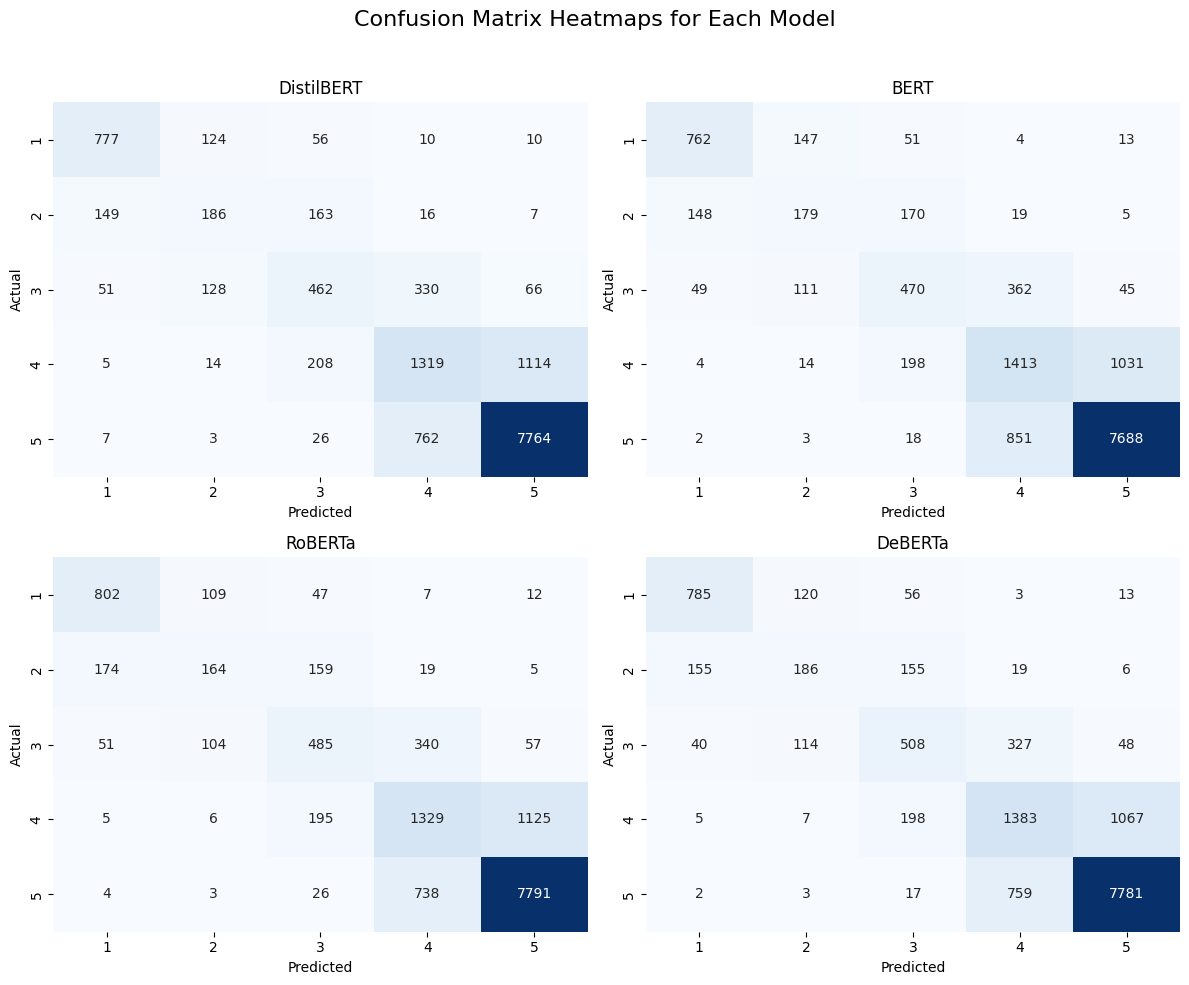

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix görselleştirmesi
model_names = ["DistilBERT", "BERT", "RoBERTa", "DeBERTa"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Confusion Matrix Heatmaps for Each Model", fontsize=16)

# 1-5 yıldız etiketleri
star_labels = [1, 2, 3, 4, 5]

for ax, name in zip(axes.flat, model_names):
    cm = confusion_matrices[name]
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=ax,
        cbar=False,
        xticklabels=star_labels,
        yticklabels=star_labels
    )
    ax.set_title(f"{name}", fontsize=12)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Başlıkla çakışmasın
plt.show()


100%|██████████| 300/300 [00:07<00:00, 38.43it/s]


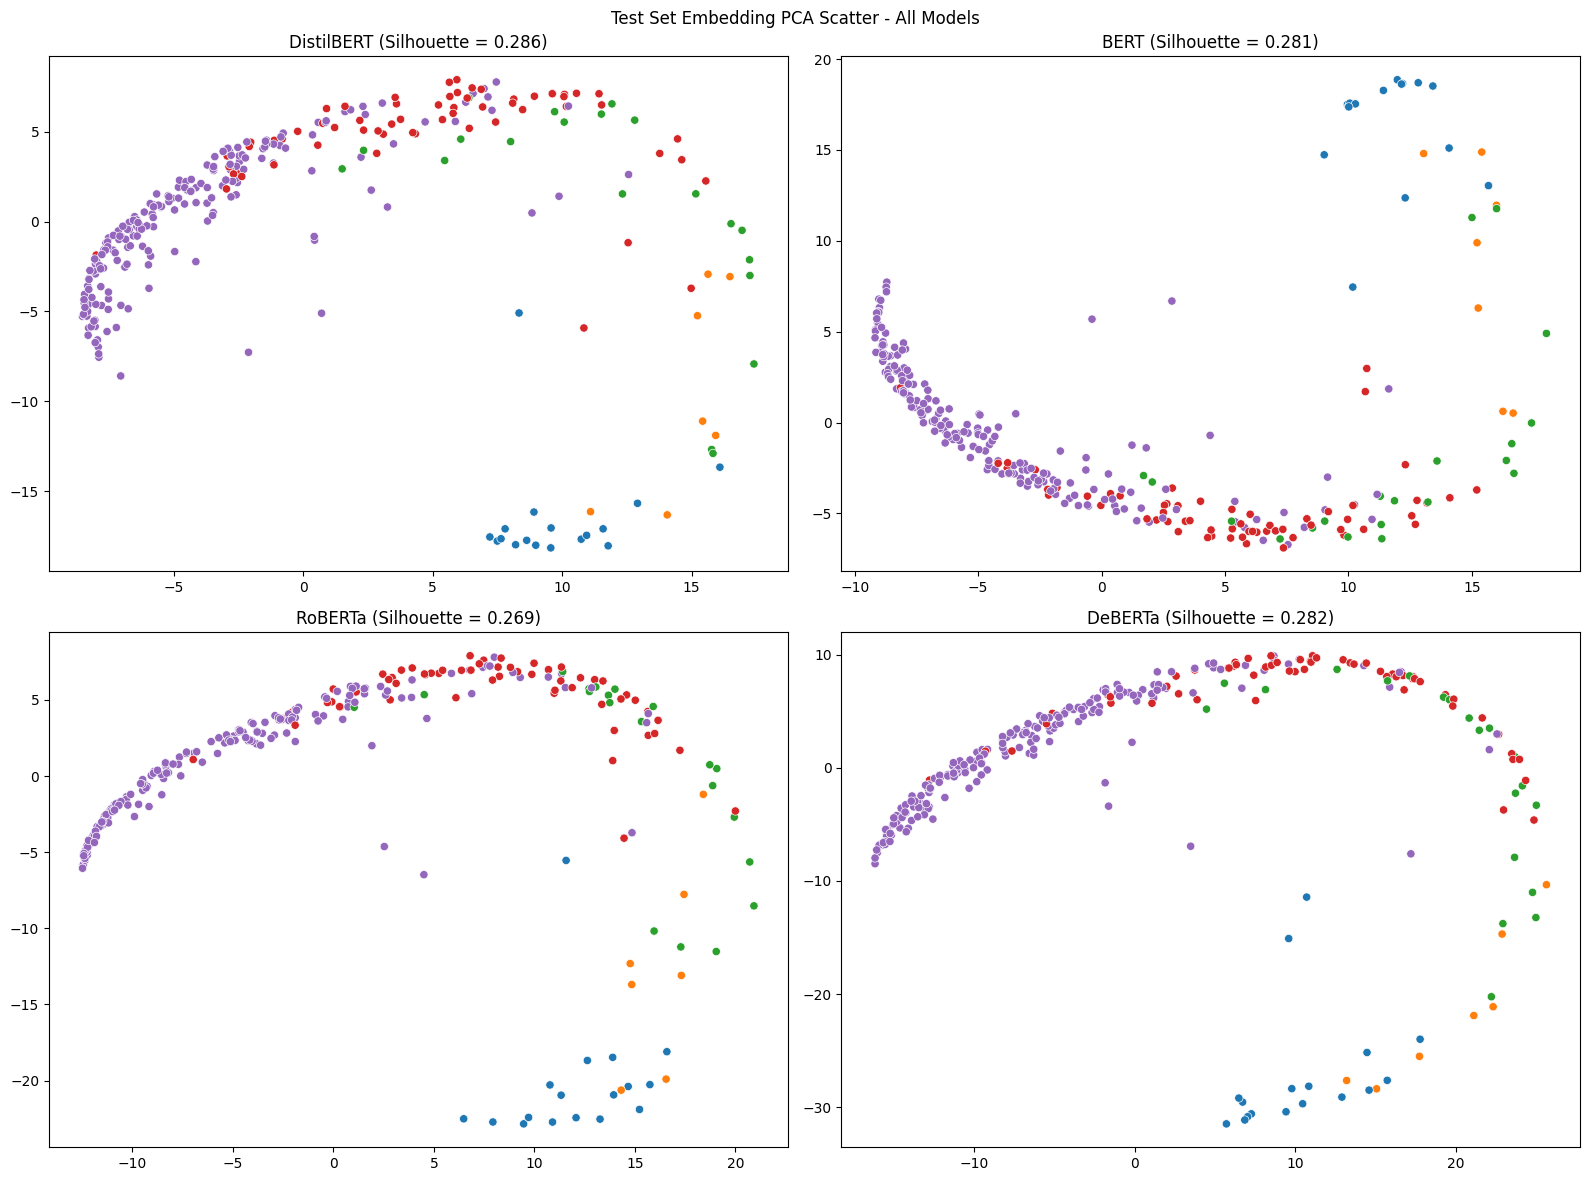


Silhouette Scores:
DistilBERT: 0.286
BERT: 0.281
RoBERTa: 0.269
DeBERTa: 0.282


In [15]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

from tqdm import tqdm

def extract_embeddings(model, tokenizer, texts):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts):
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True, return_dict=True)
            hidden_states = outputs.hidden_states[-1]  # last layer
            cls_embedding = hidden_states[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(cls_embedding)
    return np.vstack(embeddings)

# Örnekleme yapalım (tüm test seti yerine 300 yorum seçelim)
sample_df = test_df.sample(300, random_state=42).reset_index(drop=True)
sample_texts = sample_df['review_text'].tolist()
sample_labels = sample_df['rating'].values

# Tüm modeller için embed ve PCA
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

silhouette_scores = {}

for i, (name, model) in enumerate(trained_models.items()):
    tokenizer = AutoTokenizer.from_pretrained(models[name], use_fast=False)
    embeds = extract_embeddings(model, tokenizer, sample_texts)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeds)
    sil_score = silhouette_score(reduced, sample_labels)
    silhouette_scores[name] = sil_score

    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=sample_labels, palette='tab10', ax=axes[i], legend=False)
    axes[i].set_title(f"{name} (Silhouette = {sil_score:.3f})")

plt.suptitle("Test Set Embedding PCA Scatter - All Models")
plt.tight_layout()
plt.show()

# Sonuçları yazdıralım
print("\nSilhouette Scores:")
for name, score in silhouette_scores.items():
    print(f"{name}: {score:.3f}")